In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    LandmarkLagrangianProcess, LandmarkLagrangianAuxProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLP, MLPSmall
from neuralbridge.models import neurb, pCN
from neuralbridge.utils.plotting import plot_landmark_sample_path

In [3]:
n_landmarks = 16        # number of landmarks
m_landmarks = 2         # number of dimensions per landmark
dim = n_landmarks * m_landmarks

T = 1.0
dt = 1. / 100
dtype = jnp.float32

k_alpha = 0.1
k_sigma = 0.25

seed = 42

# u = jnp.array([[-0.05],
#                [0.05],
#                [0.5]], dtype=dtype).flatten()
# v = jnp.array([[-0.2],
#                [0.2],
#                [0.5]], dtype=dtype).flatten()
u = jnp.linspace(0.0, 2.0*jnp.pi, num=n_landmarks, endpoint=False)
u = jnp.stack([jnp.sin(u), jnp.cos(u)], axis=-1).flatten()
# v = 1.3 * u

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [4]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc = WienerProcess(T=T, dt=dt, dim=dim, t_scheme=t_scheme, dtype=dtype)
ori_proc = LandmarkLagrangianProcess(
    k_alpha=k_alpha,
    k_sigma=k_sigma,
    n_landmarks=n_landmarks,
    m_landmarks=m_landmarks,
    T=T,
    dtype=dtype
)
aux_proc = LandmarkLagrangianAuxProcess(
    k_alpha=k_alpha,
    k_sigma=k_sigma,
    n_landmarks=n_landmarks,
    m_landmarks=m_landmarks,
    T=T,
    dtype=dtype
)
aux_proc.init_g(x0=u)
# aux_proc.g0 = k_alpha * jnp.eye(dim, dtype=dtype)

ori_solver = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver = Euler(sde=aux_proc, wiener=wiener_proc)

In [5]:
ori_path = ori_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

<Axes: title={'center': 'Original Process'}, xlabel='$x$', ylabel='$y$'>

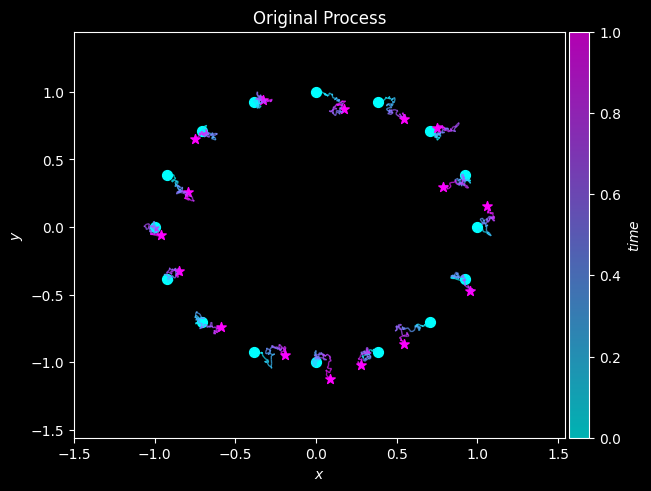

In [6]:
plot_landmark_sample_path(ori_path[1], m_landmarks, title="Original Process", cmap="cool")

<Axes: title={'center': 'Auxiliary Process'}, xlabel='$x$', ylabel='$y$'>

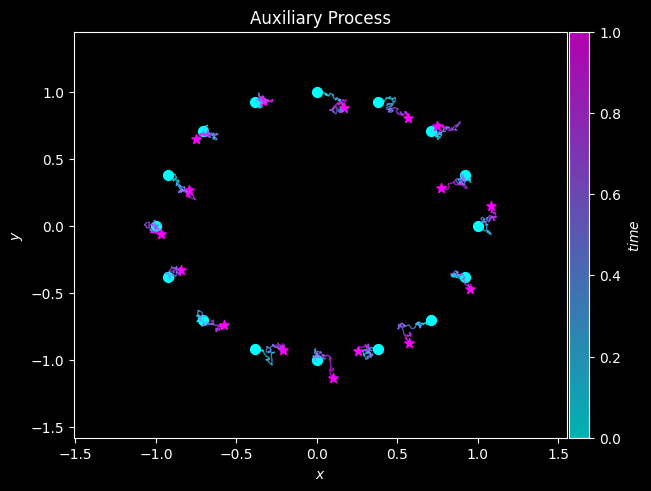

In [7]:
aux_path = aux_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
plot_landmark_sample_path(aux_path[1], m_landmarks, title="Auxiliary Process", cmap="cool")

In [9]:
v = ori_path.xs[0, -1, :] # take the final point of the unconditional process as the target

In [14]:
guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype) * 1e-3,
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)
guided_solver = Euler(sde=guided_proc, wiener=wiener_proc)

In [15]:
guided_path = guided_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16, enforce_end_point=v)

<Axes: title={'center': 'Guided Process'}, xlabel='$x$', ylabel='$y$'>

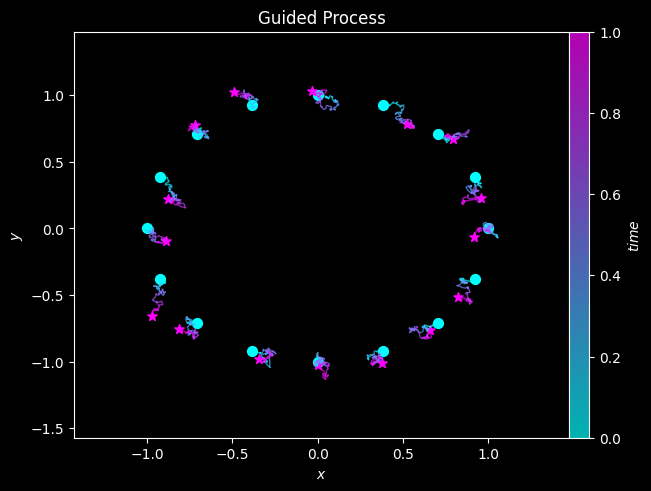

In [16]:
plot_landmark_sample_path(guided_path[1], m_landmarks, title="Guided Process", cmap="cool")

In [17]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(32, 32, 32, 32),
    activation="tanh",
    norm=None
)

In [39]:
train_config = {
    "save_name": "landmarks_circle",
    "seed": seed,
    "learning_rate": 1e-4,
    "batch_size": 4,
    "n_iters": 10,
    "n_epochs": 1,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": 1.0,
    "warmup_steps": 0
}

In [40]:
neural_bridge = neurb.NeuralBridge(
    guided_bridge=guided_proc,
    neural_net=neural_net,
    train_config=train_config
)
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)

In [44]:
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/10 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss:     nan


Average gradient norm: nan
Average gradient norm: nan
Average gradient norm: nan
Average gradient norm: nan
Average gradient norm: nan
Average gradient norm: nan
Average gradient norm: nan
Average gradient norm: nan
Average gradient norm: nan
Average gradient norm: nan


INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle/epoch_1


In [87]:
pCN_config = {
    "seed": seed,
    "rho": 0.98,
    "batch_size": 16,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=guided_proc, run_config=pCN_config)
pCN_model.initialize_path_solver(wiener_proc)
pCN_result = pCN_model.run_pCN(log_every=1000)

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

INFO:root:Iteration 0/10000: log likelihood = -1686.894287109375
INFO:root:Iteration 1000/10000: log likelihood = 216182.390625
INFO:root:Iteration 2000/10000: log likelihood = 259984.546875
INFO:root:Iteration 3000/10000: log likelihood = 268973.84375
INFO:root:Iteration 4000/10000: log likelihood = 273002.15625
INFO:root:Iteration 5000/10000: log likelihood = 275475.53125
INFO:root:Iteration 6000/10000: log likelihood = 279204.03125
INFO:root:Iteration 7000/10000: log likelihood = 280490.6875
INFO:root:Iteration 8000/10000: log likelihood = 281700.34375
INFO:root:Iteration 9000/10000: log likelihood = 283016.53125
INFO:root:Batch average acceptance rate: 3.03%


<Axes: title={'center': 'PCN Process'}, xlabel='$t$', ylabel='$X_t$'>

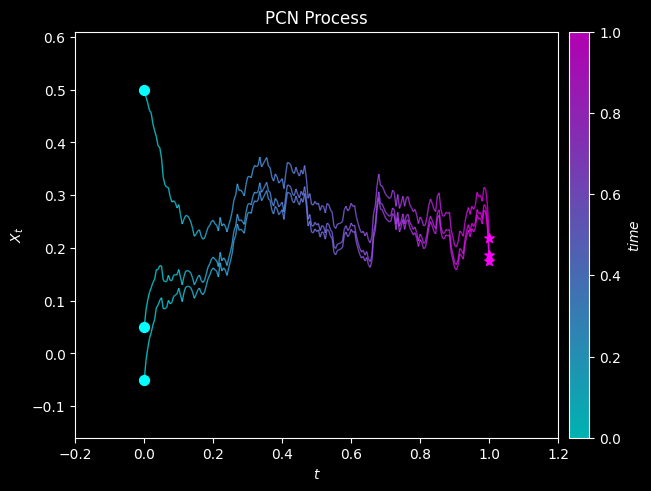

In [89]:
plot_landmark_sample_path(pCN_result.path_X[1], m_landmarks, title="PCN Process", cmap="cool")
